In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import pylab
import matplotlib.pyplot as plt

import numpy as np
%matplotlib inline

import logging

logger = logging.getLogger("logger")    #logger名loggerを取得
logger.setLevel(logging.DEBUG)  #loggerとしてはDEBUGで

#handler1を作成
handler1 = logging.StreamHandler()
handler1.setFormatter(logging.Formatter("%(asctime)s %(levelname)8s %(message)s"))

import os



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
import labnote as lb
if lb.utils.is_executed_on_ipython():
    %reload_ext autoreload
    %autoreload 2

note = lb.Note(arguments=['conf_train_args.yaml',{'config':'conf_AE.yaml'}])


# Fix seed
if 'seed' in note.params.keys():
    np.random.seed(note.params.seed)
    _ = torch.manual_seed(note.params.seed)

/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/labnote/core.py:71: UserWarning: Please set your script file name to 'script_name'.
  warn("Please set your script file name to 'script_name'.")
/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/labnote/core.py:72: UserWarning: ex) note.script_name = xxx.ipynb
  warn("ex) note.script_name = xxx.ipynb")
/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/labnote/core.py:73: UserWarning: NOTE: This warning may happen if you are using jupyter in a docker, and access via port-forwarding. Using jupyter with password authentification can be another possibility.
  warn("NOTE: This warning may happen if you are using jupyter in a docker, and access via port-forwarding. Using jupyter with password authentification can be another possibility.")


torch.Size([60000, 28, 28])
torch.Size([60000])


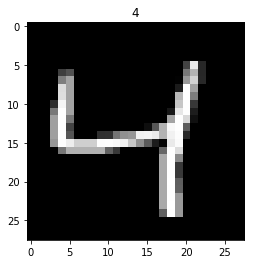

In [4]:
# Mnist digits dataset
train_data = MNIST(
    root='./data/mnist/',
    train=True,                                     # this is training data
    transform=transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=True,                        # download it if you don't have it
)
# plot one example
print(train_data.train_data.size())     # (60000, 28, 28)
print(train_data.train_labels.size())   # (60000)
plt.imshow(train_data.train_data[2].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[2])
plt.show()

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = DataLoader(dataset=train_data, batch_size=note.params.batch_size, shuffle=True)


In [6]:
from sys import stdout
import src.utils as my
import src.network as net


AE = net.AutoEncoder(note.params,logger,input_dim=1, gpu=note.params.gpu)
optimizer = eval(note.params.optimizer.format('AE',note.params.learning_rate))

epoch = 0
global_step = 0
AE.train()

try:
    writer.close()
    my.reset_tensorboard(note.params.output)
except:
    pass
from tensorboardX import SummaryWriter
writer = SummaryWriter(note.params.output)

def to_gpu(x):
    gpu = 0
    if note.params.gpu<-1:
        return x
    if note.params.gpu==-1:
        gpu = 0
    else:
        gpu = note.params.gpu
    return x.cuda(gpu)
def to_cpu(x):
    if note.params.gpu<-1:
        return x
    return x.cpu()

for epoch in range(0,note.params.num_epochs):
    for batch_idx, (x,y) in enumerate(train_loader):
        x_true = to_gpu(x)
        x = to_gpu(2*x-1)
        y = to_gpu(y)
        optimizer.zero_grad()
        z,x_pred = AE.forward(x)
        # z = z.detach() # to use z for further calculation.        
        
        # calc reconstruction loss
        l = AE.calc_loss('reconstruction',global_step,x_pred,x_true, writer=writer)
        l.backward()
        
        
        optimizer.step()
        if batch_idx % 100 == 0:
            x_show = np.hstack([to_cpu(x_true[0]).detach(),to_cpu(x_pred[0]).detach()])
            writer.add_image('x_pred_epoch%03d'%epoch, x_show, global_step)

       
        loss_data = to_cpu(l.detach()).numpy()
        stdout.write(
            'Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'.
            format(epoch, note.params.num_epochs, batch_idx * len(x), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), loss_data))        
        global_step += 1

/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


In [7]:
# model save/load test.

model_path = os.path.join(note.params.output,'model')
AE.save(model_path)

In [8]:
AE2 = net.AutoEncoder.load(model_path,logger=logger,input_dim=1, gpu=note.params.gpu)
optimizer2 = eval(note.params.optimizer.format('AE2',note.params.learning_rate))

In [9]:
for x,y in train_loader:
    x_true = to_gpu(x)
    x = to_gpu(2*x-1)
    optimizer2.zero_grad()
    z,x_pred = AE2.forward(x)
    # z = z.detach() # to use z for further calculation.        

    # calc reconstruction loss
    l = AE.calc_loss('reconstruction',global_step,x_pred,x_true)
    l.backward()
    optimizer2.step()
    
    loss_data = to_cpu(l.detach()).numpy()
    stdout.write(
        'Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'.
        format(epoch, note.params.num_epochs, batch_idx * len(x), len(train_loader.dataset),
               100. * batch_idx / len(train_loader), loss_data))   

/opt/pyenv/versions/3.6.5/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
